In [2]:
import sys
import os
import numpy as np
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import metpy.calc as mpc
from metpy.units import units
# for animations
from PIL import Image

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# aggregation indices
os.chdir('/data2/willytsai/python_module')
import conorgidx_revise as agi
from SCAI_calc4obj import labeled_obj, SCAI_calc
from COP_calc4obj import COP
from MICA_calc4obj import MICA
import conorgidx as agi_ori

In [5]:
from multiprocessing import Pool

In [6]:
def running_mean(y,window_N):
    y_avg = np.zeros(len(y))
    avg_mask = np.ones(window_N) / window_N

    y_avg = np.convolve(y, avg_mask, 'same')
    y_avg[-window_N:] = y[-window_N:]
    y_avg[:window_N] = y[:window_N]
    return y_avg    

In [7]:
def read_data(data_name,t_start=0,t_end=721):
    os.chdir(server+data_name)
    data_2d = xr.open_dataset('cm1out_2Dvars.nc')
    # 2d data
    prate = data_2d.prate[t_start:t_end,:,:]
    
    return (prate*3600*24)

In [8]:
# get weather or weather2 
server = '/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'
exp_name = ['CM1_RAD4K_RCEP_240x240_CTRL']

os.chdir(server)
os.system('mkdir -p fig_sum') # create a figure archive
fig_dir = server+'fig_sum/' 

In [9]:
# read precip dat
prate = read_data(exp_name[0],t_start=360,t_end=721)
x_dim = prate.lon
y_dim = prate.lat

In [10]:
def scai_scene(i):
    
    prate_all = prate[i,:,:].values
    # central region 
    prate_cen = prate[i,len(y_dim)//4:len(y_dim)//4*3,:].values
    prate_cen = np.tile(prate_cen, reps=(2,1))
    
    # outer region
    prate_out = np.concatenate([prate[i,:len(y_dim)//4,:].values, prate[i,-len(y_dim)//4:,:].values])
    prate_out = np.tile(prate_out, reps=(2,1))
    
    labeled_array, num_feature = labeled_obj(prate_all/24,cri=1,flag=1)
    scai_all = SCAI_calc(labeled_array, num_feature, dx=2, L=prate.lat[-1])
    
    labeled_array, num_feature = labeled_obj(prate_cen/24,cri=1,flag=1)
    scai_cen = SCAI_calc(labeled_array, num_feature, dx=2, L=prate.lat[-1]//2)

    labeled_array, num_feature = labeled_obj(prate_out/24,cri=1,flag=1)
    scai_out = SCAI_calc(labeled_array, num_feature, dx=2, L=prate.lat[-1]//2)

    return scai_all, scai_cen, scai_out

In [11]:
def COP_scene(i):
    
    prate_all = prate[i,:,:].values
    # central region 
    prate_cen = prate[i,len(y_dim)//4:len(y_dim)//4*3,:].values
    prate_cen = np.tile(prate_cen, reps=(2,1))
    
    # outer region
    prate_out = np.concatenate([prate[i,:len(y_dim)//4,:].values, prate[i,-len(y_dim)//4:,:].values])
    prate_out = np.tile(prate_out, reps=(2,1))
    
    labeled_array, num_feature = labeled_obj(prate_all/24,cri=1,flag=1)
    cldmask = np.copy(labeled_array)*0 
    cldmask[labeled_array>0] = 1
    cop_all = COP(cldmask)
    
    labeled_array, num_feature = labeled_obj(prate_cen/24,cri=1,flag=1)
    cldmask = np.copy(labeled_array)*0 
    cldmask[labeled_array>0] = 1
    cop_cen = COP(cldmask)
    
    labeled_array, num_feature = labeled_obj(prate_out/24,cri=1,flag=1)
    cldmask = np.copy(labeled_array)*0 
    cldmask[labeled_array>0] = 1
    cop_out = COP(cldmask)
    
    return cop_all, cop_cen, cop_out

In [12]:
def Iorg_scene(i):
    
    prate_all = prate[i,:,:].values
    # central region 
    prate_cen = prate[i,len(y_dim)//4:len(y_dim)//4*3,:].values
    prate_cen = np.tile(prate_cen, reps=(2,1))
    
    # outer region
    prate_out = np.concatenate([prate[i,:len(y_dim)//4,:].values, prate[i,-len(y_dim)//4:,:].values])
    prate_out = np.tile(prate_out, reps=(2,1))
    
    labeled_array, num_feature = labeled_obj(prate_all/24,cri=1,flag=1)
    cldmask = np.copy(labeled_array)*0 
    cldmask[labeled_array>0] = 1
    Iorg_all = agi.iorg(cldmask)
    
    labeled_array, num_feature = labeled_obj(prate_cen/24,cri=1,flag=1)
    cldmask = np.copy(labeled_array)*0 
    cldmask[labeled_array>0] = 1
    Iorg_cen = agi.iorg(cldmask)
    
    labeled_array, num_feature = labeled_obj(prate_out/24,cri=1,flag=1)
    cldmask = np.copy(labeled_array)*0 
    cldmask[labeled_array>0] = 1
    Iorg_out = agi.iorg(cldmask)
    
    return Iorg_all, Iorg_cen, Iorg_out

In [13]:
%%time
# multiprocessing for t loop
proccess_pool = Pool()
df = proccess_pool.map(scai_scene,range(prate.shape[0]))
SCAI_time = np.asarray(df)
print(SCAI_time.shape)

proccess_pool.close()
proccess_pool.join()    

(361, 3)
CPU times: user 389 ms, sys: 396 ms, total: 786 ms
Wall time: 42.5 s


In [14]:
%%time
# multiprocessing for t loop
proccess_pool = Pool()
df2 = proccess_pool.map(COP_scene,range(prate.shape[0]))
COP_time = np.asarray(df2)
print(COP_time.shape)

proccess_pool.close()
proccess_pool.join()    

(361, 3)
CPU times: user 160 ms, sys: 276 ms, total: 436 ms
Wall time: 1min


In [15]:
%%time
# multiprocessing for t loop
proccess_pool = Pool()
df3 = proccess_pool.map(Iorg_scene,range(prate.shape[0]))
Iorg_time = np.asarray(df3)
print(Iorg_time.shape)

proccess_pool.close()
proccess_pool.join()    

(361, 3)
CPU times: user 76 ms, sys: 224 ms, total: 300 ms
Wall time: 8.54 s


In [16]:
# save aggregation indices 
os.system('mkdir -p ./data_out') # create output for later
os.chdir(server+exp_name[0]+'/data_out')

np.save('SCAI_time.npy',SCAI_time)
np.save('COP_time.npy',COP_time)
np.save('Iorg_time.npy',Iorg_time)

### Diagnosis section for existing outputs

In [17]:
# combine all outputs
server = '/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'
exp_name = ['CM1_RAD4K_RCEP_240x240_CTRL',
            'CM1_RAD4K_RCEP_240x240_lowU05',
            'CM1_RAD4K_RCEP_240x240_lowU07',
            'CM1_RAD4K_RCEP_240x240_lowU10',
            'CM1_RAD4K_RCEP_240x240_lowU10',
            'CM1_RAD4K_RCEP_240x240_lowU15',
            'CM1_RAD4K_RCEP_240x240_lowU05_UNI',
            'CM1_RAD4K_RCEP_240x240_lowU10_UNI',
            'CM1_RAD4K_RCEP_240x240_lowU15_UNI']

exp_short = ['CTRL','U05','U07','U10','U12','U15','U05_UNI','U10_NUI','U15_NUI']

Text(0, 0.5, 'COP')

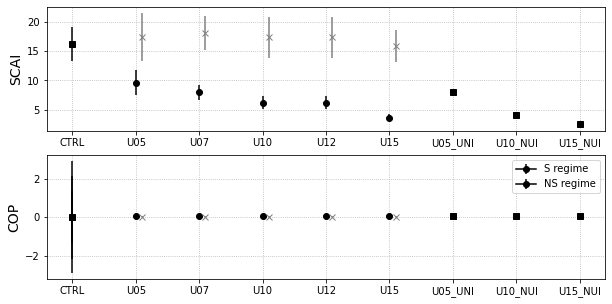

In [27]:
fig,ax = plt.subplots(2,1,figsize=(10,5))
colors = ['k','r','g','b','m','darkred','r','b','darkred']

for n,exp in enumerate(exp_name): 
    
    if n<6 :
    
        scai = np.load(server+exp+'/data_out/SCAI_time.npy')
        cop = np.load(server+exp+'/data_out/COP_time.npy')
        iorg = np.load(server+exp+'/data_out/Iorg_time.npy')

        scai_s = np.nanmean(scai[:,1],axis=0)
        scai_err_s = np.nanstd(scai[:,1],axis=0)
        cop_s = cop[:,1].mean(axis=0)     
        cop_err_s = cop[:,1].std(axis=0)     

        scai_ns = scai[:,2].mean(axis=0)
        scai_err_ns = scai[:,2].std(axis=0)
        cop_ns = cop[:,2].mean(axis=0)     
        cop_err_ns = cop[:,2].std(axis=0)             

        # for fake legend
        ax[1].errorbar(0,np.nan,yerr=scai_err_s,marker='o',color='k')
        ax[1].errorbar(0,cop_s*0,yerr=cop_err_s,marker='o',color='k')
        
        # shear region
        if n > 0:
            ax[0].errorbar(n,scai_s,yerr=scai_err_s,marker='o',color='k')
            ax[1].errorbar(n,cop_s,yerr=cop_err_s,marker='o',color='k')
        else:
            ax[0].errorbar(n,scai_s,yerr=scai_err_s,marker='s',color='k')
            ax[1].errorbar(n,cop_s,yerr=cop_err_s,marker='s',color='k')
        # non-shear region
        if n > 0:
            ax[0].errorbar(n+0.1,scai_ns,yerr=scai_err_ns,marker='x',color='grey')
            ax[1].errorbar(n+0.1,cop_ns,yerr=cop_err_ns,marker='x',color='grey')
            
    else:
        scai = np.load(server+exp+'/data_out/SCAI_time.npy')
        cop = np.load(server+exp+'/data_out/COP_time.npy')
        iorg = np.load(server+exp+'/data_out/Iorg_time.npy')
        
        scai_s = np.nanmean(scai[:,0],axis=0)
        scai_err_s = np.nanstd(scai[:,0],axis=0)
        cop_s = cop[:,0].mean(axis=0)     
        cop_err_s = cop[:,0].std(axis=0)     

        # shear region    
        ax[0].errorbar(n,scai_s*2,yerr=scai_err_s,marker='s',color='k')
        ax[1].errorbar(n,cop_s,yerr=cop_err_s,marker='s',color='k')
        
ax[1].legend(['S regime','NS regime'])
ax[0].set_xticks(np.arange(len(exp_name)))
ax[0].set_xticklabels(exp_short);ax[0].grid(linestyle=':')
ax[0].set_ylabel('SCAI',fontsize=14)
ax[1].set_xticks(np.arange(len(exp_name)))
ax[1].set_xticklabels(exp_short);ax[1].grid(linestyle=':')
ax[1].set_ylabel('COP',fontsize=14)
#fig.savefig(server+'fig_sum/'+'OrgIndices_all.pdf',bbox_inches='tight',transparent=False)

TypeError: can only concatenate list (not "str") to list

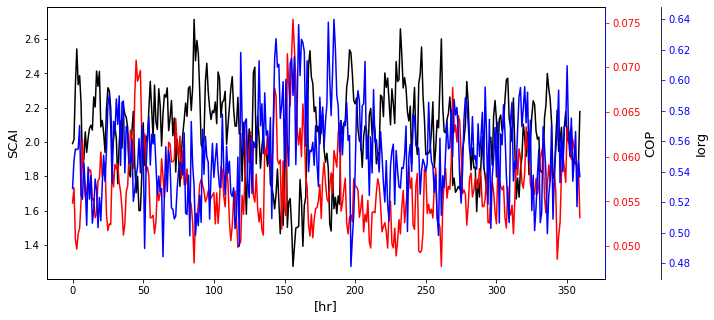

In [41]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(SCAI_time[-360:,0],'k') # SCAI_PR
ax2 = ax.twinx()
ax2.plot(COP_time[-360:,0],'r') # SCAI_PR
ax3 = ax.twinx()
ax3.spines['right'].set_position(("axes", 1.1))
ax3.plot(Iorg_time[-360:,0],'b') # SCAI_PR

ax.set_ylabel('SCAI',fontsize=13)
ax2.set_ylabel('COP',fontsize=13)
ax3.set_ylabel('Iorg',fontsize=13)
ax.set_xlabel('[hr]',fontsize=13)

ax2.spines["right"].set_color('r')
ax2.tick_params(axis='y', colors='r')
ax2.spines["right"].set_color('b')
ax3.tick_params(axis='y', colors='b')

ax.set_title(exp_name+'\n Aggregation Index, last 5 days')
#fig.savefig(fig_dir+'AggIndex_timeseries.pdf',dpi=200,bbox_inches='tight')
#plt.close()
#print('AggIndex_timeseries.pdf')